In [1]:
import os
import sys
sys.path.append(os.path.expandvars("$HOME/NEXT/NEXT100-0nubb-analysis"))
import glob
import numpy  as np
import pandas as pd

# from iminuit import Minuit

from invisible_cities.evm.mixer import get_file_number
from invisible_cities.io.dst_io import load_dst, load_dsts

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

In [2]:
def load_dsts_with_info(inpath, isotope, g4volume, group, table, nfiles=100):
    
    filenames = sorted( glob.glob(inpath.format(isotope=isotope, g4volume=g4volume))
                      , key = get_file_number)
    
    dst = pd.DataFrame()
    for filename in filenames[:nfiles]:
        dst_ = load_dst(filename, group, table)
        dst_.loc[:, "file"] = get_file_number(filename)
        dst = pd.concat([dst, dst_])
    return dst

In [3]:
inpath = os.path.expandvars("$HOME/NEXT/DATA/backgrounds/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

In [4]:
isotope  = "0nubb"
g4volume = "/"

filenames = sorted( glob.glob(inpath.format(isotope=isotope, g4volume=g4volume))
                  , key = get_file_number)

In [5]:
dsts   = load_dsts_with_info(inpath, isotope, g4volume,      "DST", "Events", nfiles=500)
tracks = load_dsts_with_info(inpath, isotope, g4volume, "Tracking", "Tracks", nfiles=500)

## Number of signals

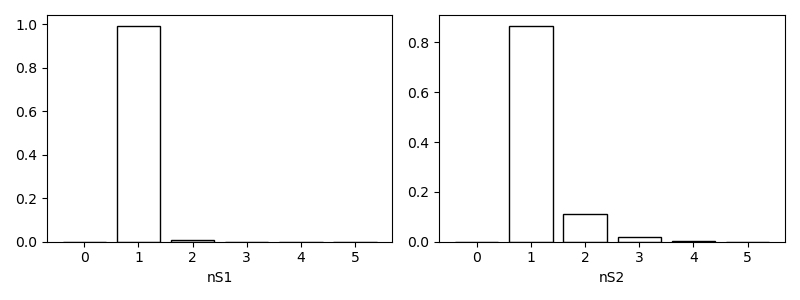

In [9]:
fig = plt.figure(figsize=[8, 3])

bins  = np.arange(-0.5, 6.5)
binsc = (bins[1:] + bins[:-1])/2. 
get_number_signals = lambda signal: dsts.groupby(["event", "time"]).apply(lambda df: df[signal].max()).values

for i, signal in enumerate(("nS1", "nS2"), 1):
    ax = fig.add_subplot(1, 2, i)
    h, _ = np.histogram(get_number_signals(signal), bins=bins)
    ax.set_xlabel(signal)
    ax.bar(binsc, h/h.sum(), tick_label=binsc.astype(int), color="none", edgecolor="k")
    fig.tight_layout()

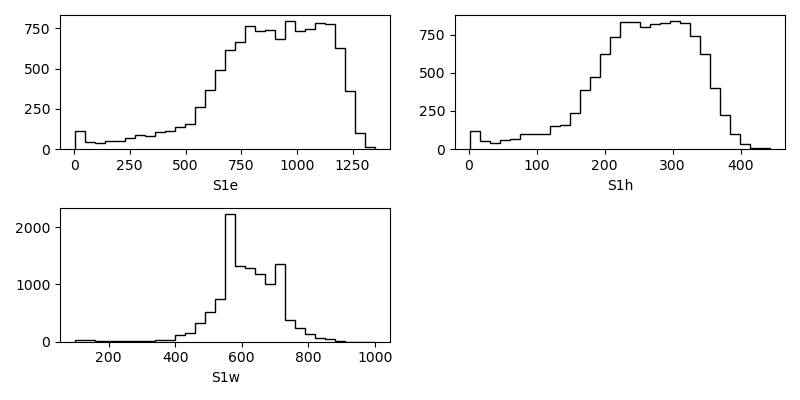

In [10]:
fig = plt.figure(figsize=[8, 4])

for i, var in enumerate(("S1e", "S1h", "S1w"), 1):
    ax = fig.add_subplot(2, 2, i)
    ax.set_xlabel(var)
    ax.hist(dsts[var], bins=30, histtype="step", color="k")
    fig.tight_layout()

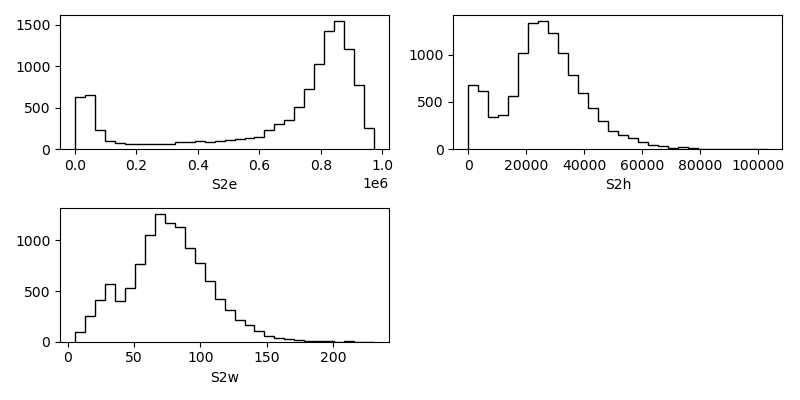

In [11]:
fig = plt.figure(figsize=[8, 4])

for i, var in enumerate(("S2e", "S2h", "S2w"), 1):
    ax = fig.add_subplot(2, 2, i)
    ax.set_xlabel(var)
    ax.hist(dsts[var], bins=30, histtype="step", color="k")
    fig.tight_layout()

## Tracks

In [12]:
sel = dsts.loc[(dsts.nS1 == 1) & (dsts.nS2 == 1), ("event", "file")]
tracks = tracks.set_index(["event", "file"]).loc[sel.values.tolist()]

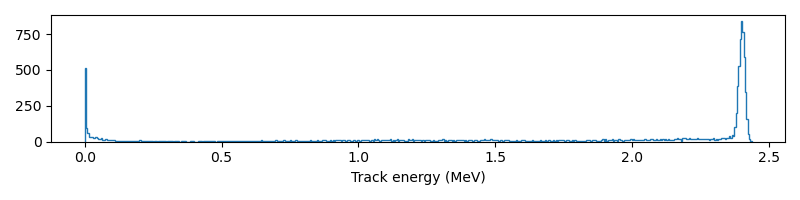

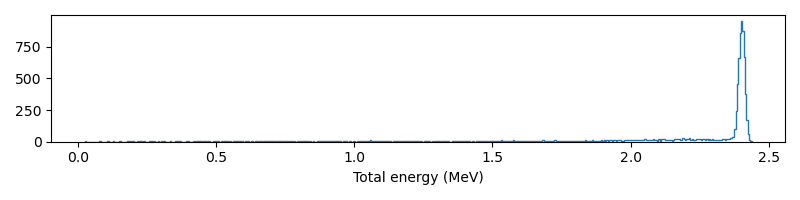

In [13]:
fig = plt.figure(figsize=[8, 2])
ax = fig.add_subplot(111)
ax.hist(tracks.energy, bins=500, histtype="step")
ax.set_xlabel("Track energy (MeV)")
fig.tight_layout();


fig = plt.figure(figsize=[8, 2])
ax = fig.add_subplot(111)
ax.hist(tracks.groupby(level=[0,1]).energy.sum(), bins=500, histtype="step")
ax.set_xlabel("Total energy (MeV)")
fig.tight_layout();

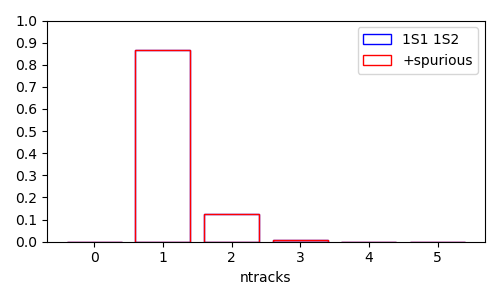

In [35]:
fig = plt.figure(figsize=[5, 3])

bins  = np.arange(-0.5, 6.5)
binsc = (bins[1:] + bins[:-1])/2.

# 1S1 1S2 selection
ax = fig.add_subplot(1, 1, 1)

h, _ = np.histogram(tracks.groupby(level=[0, 1]).trackID.nunique(), bins=bins)
ax.set_xlabel("ntracks")
ax.bar(binsc, h/h.sum(), tick_label=binsc.astype(int), color="none", edgecolor="b", label="1S1 1S2")

# spurious selection
tracks_ = tracks.loc[tracks.energy>0.01]

h, _ = np.histogram(tracks_.groupby(level=[0, 1]).trackID.nunique(), bins=bins)
ax.set_xlabel("ntracks")
ax.bar(binsc, h/h.sum(), tick_label=binsc.astype(int), color="none", edgecolor="r", label="+spurious")
ax.set_yticks(np.arange(0, 1.1, 0.1))
fig.tight_layout()
ax.legend()

In [15]:
# remove spurious tracks and assign energy to largest energy track:
# sum spurious track energies to max energy track and
# correct numb_of_tracks values

tracks = tracks.set_index("trackID", append=True)

sel_spurious = (tracks.energy < 0.01)
spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

# trackID of max energy track
trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                .set_index("trackID", append=True).groupby(level=[0, 1]) \
                .apply(lambda df: df.energy.idxmax()[-1])
trackID.name = "trackID"

# sum spurious energy to max energy track
spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                    .set_index("trackID", append=True)
tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

# drop spurious
tracks = tracks.loc[~sel_spurious].reset_index("trackID")
# correct numb of tracks
tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

# how-to select spurious events
# event_has_spurious = sel_spurious.to_frame().groupby(level=[0, 1]).energy.any()
# tracks.reset_index("trackID").loc[event_has_spurious]

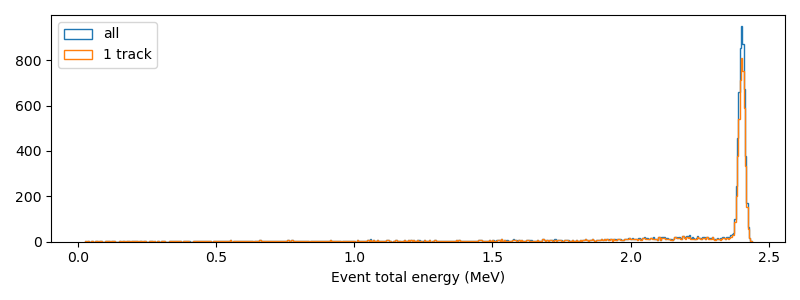

In [38]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

_, bins, _ = ax.hist(tracks.groupby(level=[0, 1]).energy.sum(), bins=500, histtype="step", label="all")

sel = (tracks.numb_of_tracks == 1)
ax.hist(tracks.loc[sel].energy, bins=bins, histtype="step", label="1 track")

ax.set_xlabel("Event total energy (MeV)")
ax.legend(loc="upper left")
fig.tight_layout();

In [40]:
# 1 track selection
sel = (tracks.numb_of_tracks == 1)
tracks = tracks.loc[sel]

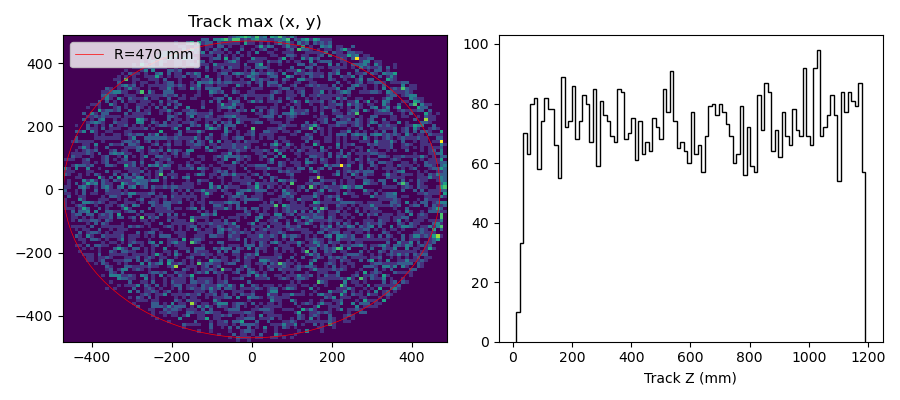

In [41]:
fig = plt.figure(figsize=[9, 4])
ax = fig.add_subplot(121)
ax.hist2d(tracks.x_max, tracks.y_max, bins=100)
ax.set_title("Track max (x, y)")
fig.tight_layout();

r = 470
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(r*np.cos(theta), r*np.sin(theta), label=f"R={r} mm", color="r", linewidth=0.5)
ax.legend(loc="upper left")

ax = fig.add_subplot(122)
ax.hist(tracks.z_ave, bins=100, histtype="step", color="k")
ax.set_xlabel("Track Z (mm)")
fig.tight_layout();

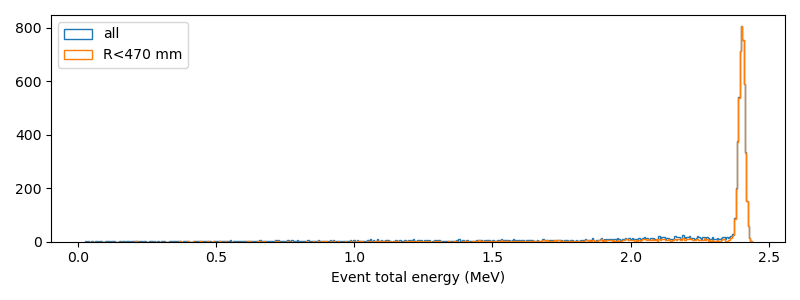

In [45]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

_, bins, _ = ax.hist(tracks.groupby(level=[0, 1]).energy.sum(), bins=500, histtype="step", label="all")

rmax = 470
sel = tracks.groupby(level=[0, 1]).apply(lambda df: df.r_max.max()) < rmax
ax.hist(tracks.loc[sel].groupby(level=0).energy.sum(), bins=bins, histtype="step", label=f"R<{rmax} mm")

ax.set_xlabel("Event total energy (MeV)")
ax.legend(loc="upper left")
fig.tight_layout();

In [60]:
0.02*41.55

0.831

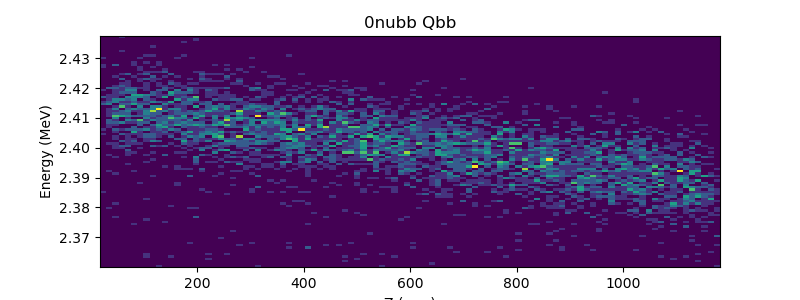

In [65]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

sel = tracks.energy>2.36
ax.hist2d(tracks.loc[sel].z_ave, tracks.loc[sel].energy, bins=100);
ax.set_title("0nubb Qbb")
ax.set_xlabel("Z (mm)")
ax.set_ylabel("Energy (MeV)");

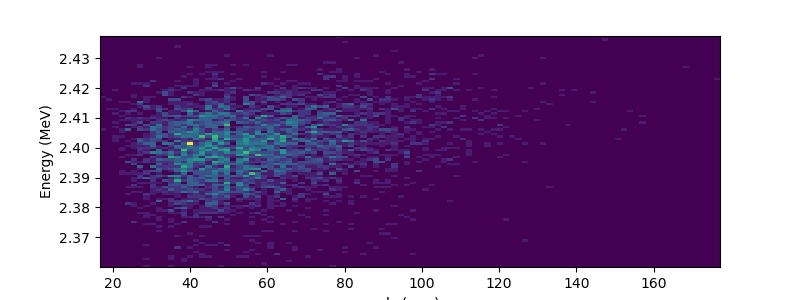

In [57]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

sel = tracks.energy>2.36
ax.hist2d((tracks.loc[sel].z_max - tracks.loc[sel].z_min), tracks.loc[sel].energy, bins=100);
ax.set_xlabel("dz (mm)")
ax.set_ylabel("Energy (MeV)");

In [20]:
from invisible_cities.reco.corrections import read_maps

In [21]:
krmap = "/Users/gonzalo/NEXT/DATA/LightTables/map_NEXT100_MC.h5"

In [22]:
maps = read_maps(krmap)

In [17]:
# inpath_ = '/Users/gonzalo/NEXT/DATA/backgrounds/{isotope}/{g4volume}/prod/esmeralda/esmeralda_*.h5'
# summary = load_dsts_with_info(inpath_, g4volume, isotope, "Summary", "Events")

In [18]:
# fig = plt.figure(figsize=[8, 3])
# ax = fig.add_subplot(111)

# _, bins, _ = ax.hist(summary.evt_energy, bins=1000, histtype="step", label="all")

# ax.set_xlabel("Event total energy (MeV)")
# ax.legend()
# fig.tight_layout();

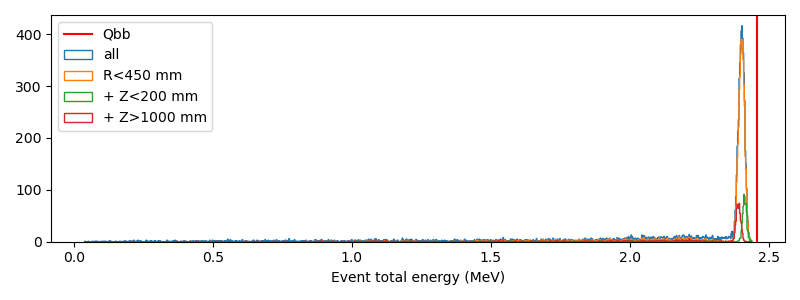

In [75]:
fig = plt.figure(figsize=[8, 3])
ax = fig.add_subplot(111)

# 1 track cut
tracks_ = tracks[tracks.energy>0.03]
ntracks = tracks_.groupby(level=[0, 1]).trackID.nunique()
# whole event with spurious tracks
tracks_ = tracks.loc[tracks_.index]
tracks_.numb_of_tracks = ntracks
tracks_ = tracks_[tracks_.numb_of_tracks == 1]

_, bins, _ = ax.hist(tracks_.groupby(level=[0, 1]).energy.sum(), bins=1000, histtype="step", label="all")

rmax = 450
sel = tracks_.r_max<rmax
ax.hist(tracks_.loc[sel].groupby(level=[0, 1]).energy.sum(), bins=bins, histtype="step", label=f"R<{rmax} mm")

sel = (tracks_.r_max<rmax)&(tracks_.z_ave<200)
ax.hist(tracks_.loc[sel].groupby(level=[0, 1]).energy.sum(), bins=bins, histtype="step", label=f"+ Z<200 mm")

sel = (tracks_.r_max<rmax)&(tracks_.z_ave>1000)
ax.hist(tracks_.loc[sel].groupby(level=[0, 1]).energy.sum(), bins=bins, histtype="step", label=f"+ Z>1000 mm")

ax.set_xlabel("Event total energy (MeV)")

ax.axvline(2.458, 0, 1, color="r", label="Qbb")
# ax.axvline(2.614, 0, 1, color="r", label="true")

ax.legend(loc="upper left")
fig.tight_layout();

## Fiducialization

In [8]:
dz = 20
bins = np.arange(0, 1250, dz)
density = False

plt.figure()

for (background, component), df in data.groupby(["background", "component"]):
#     if background == "214Bi": continue
    h, _ = np.histogram(df["z"], bins=bins, density=density)
    plt.stairs(h, bins, label=background + " " + component, linestyle="--")

plt.ylim([0, None])
plt.xlabel("Track z min position (mm)")
plt.yscale("linear")
plt.legend(fontsize=10);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
dr = 5
bins = np.arange(0, 500, dr)
density=False

plt.figure()

for (background, component), df in data.groupby(["background", "component"]):
    h, _ = np.histogram(df["rmax"], bins=bins, density=density)
    plt.stairs(h, bins, label=background + " " + component, linestyle="--")

plt.axvline(x=470, ymin=0, ymax=1, linestyle="--", linewidth=1, color="k")    
plt.ylim([0, None])
plt.xlabel("Track R max (mm)")
plt.yscale("linear")
plt.legend(fontsize=10);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
plt.figure()

plt.hist2d(data["rmax"], data["r"], bins=100)

x = np.arange(0, 500)
plt.plot(x, x, c="r")

plt.axvline(x=470, ymin=0, ymax=1, linestyle="--", linewidth=1, color="w")

plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel("R max (mm)")
plt.ylabel("R (mm)");

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Minimal radial fiducialization cut of $R_{max} =$ **470 mm** is needed to remove most of the $\beta$ from 214Bi. Then, the *efective exposure radius* is **$R_{eff}$ = 440 mm** (plot above). 

This also removes secondary tracks at high radious, probably coming by a worse deconvolution at borders.

Remove the full event with any track such that $R_{max} >$ **470 mm**.

In [21]:
sel_r_fid = (data.groupby("pevent").rmax.max() <= 470)

df = data.copy()
data = data.set_index("pevent").loc[sel_r_fid].reset_index()

100*(1-(data.groupby(["background", "region"]).pevent.nunique()/df.groupby(["background", "region"]).pevent.nunique()))

background  region           
208Tl       EP_COPPER_PLATE       4.000000
            INTERNAL_PMT_BASE     9.407148
            LIGHT_TUBE           21.185423
            OPTICAL_PAD          10.492846
            SAPPHIRE_WINDOW       8.362369
            SIPM_BOARD           11.434511
            TP_COPPER_PLATE      15.384615
214Bi       EP_COPPER_PLATE      50.000000
            INTERNAL_PMT_BASE     7.253886
            LIGHT_TUBE           74.987811
            OPTICAL_PAD           9.230769
            SAPPHIRE_WINDOW      15.151515
            SIPM_BOARD           10.735586
            TP_COPPER_PLATE      50.000000
Name: pevent, dtype: float64

In [22]:
de = 5e-3
bins = np.arange(2.0, 3.0, de)

plt.figure()

for background in data.background.unique():
    sel  = (data["background"]==background)
    h, _ = np.histogram(data.loc[sel].groupby("pevent").energy.sum(), bins=bins)
    plt.stairs(h, bins, label=background, linestyle="--")

h, _ = np.histogram(data.groupby("pevent").energy.sum(), bins=bins)
plt.stairs(h, bins, label="total")

plt.axvline(x=2.458, ymin=0, ymax=1, linestyle="--", linewidth=1, color="r", label="Qbb")    
plt.ylim([0, None])
plt.xlabel("Total event energy (MeV)")
plt.yscale("linear")
plt.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Tracks

In [23]:
signal_path = "$HOME/NEXT/pdata/0nubb/"
signal_filenames = sorted(glob.glob(os.path.expandvars(signal_path) + "/*.h5"))

In [24]:
half_life = 10.7e25 * year
nevents = np.log(2) * (6.022e23/136) * (100e3 * time/half_life)
nevents = np.random.poisson(nevents)*100

signal_data = get_pdata(signal_filenames, nevents, background="0nubb", region="ACTIVE")

NameError: name 'get_pdata' is not defined

In [46]:
# minimal cuts
# 1 peak cut
sel_1peak = (signal_data.groupby("event").peak.nunique() == 1)
pdata = signal_data.set_index("event").loc[sel_1peak].reset_index()

# E>2 MeV cut
sel_e = (signal_data.groupby("event").energy.sum() >= 2)
pdata = signal_data.set_index("event").loc[sel_e].reset_index()

# spureous tracks
signal_data = signal_data.loc[signal_data["energy"]>20e-3]
# avoid confusion, notice that a cut on tracks would bias this parameter
signal_data = signal_data.drop("ntracks", axis=1)

# fiducial cuts
sel_r_fid = (signal_data.groupby("event").rmax.max() <= 470)

signal_data = signal_data.set_index("event").loc[sel_r_fid].reset_index()

In [47]:
de = 5e-3
roi_min, roi_max = 2.42, 2.52
bins = np.arange(roi_min, roi_max, de)

plt.figure()

for background in data.background.unique():
    sel  = (data["background"]==background)
    h, _ = np.histogram(data.loc[sel].groupby("pevent").energy.sum(), bins=bins)
    plt.stairs(h, bins, label=background, linestyle="--")

hs, _ = np.histogram(signal_data.groupby("event").energy.sum(), bins=bins)
plt.stairs(hs, bins, label="0nubb", linestyle="--", color="r")

# h, _ = np.histogram(data.groupby("pevent").energy.sum(), bins=bins)
# plt.stairs(h + hs, bins, label="total")
# plt.stairs(h, bins, label="total-back", color="C2")

plt.axvline(x=2.458, ymin=0, ymax=1, linestyle="--", linewidth=1, color="r", label="Qbb")    
plt.ylim([0, None])
plt.xlabel("Total event energy (MeV)")
plt.yscale("linear")
plt.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
dn = 1
bins = np.arange(-0.5, 5.5, dn)

plt.figure()

for background in data.background.unique():
    sel  = (data["background"]==background)
    df = data[sel]
    energy = df.groupby("pevent").energy.sum()
    sel = energy[(roi_min<=energy) & (energy<=roi_max)]
    
    h, _ = np.histogram(df.set_index("pevent").loc[sel.index].groupby("pevent").track.nunique(), 
                        bins=bins, density=True)
    plt.stairs(h, bins, label=background + f"({len(sel)})", linestyle="--")

h, _ = np.histogram(data.groupby("pevent").track.nunique(), bins=bins, density=True)
plt.stairs(h, bins, label="total")

h, _ = np.histogram(signal_data.groupby("event").track.nunique(), bins=bins, density=True)
plt.stairs(h, bins, label="0nubb" + f"({len(signal_data)})", color="r")

plt.ylim([0, None])
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel("Number of tracks")
plt.yscale("linear")
plt.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
(a == 1).sum()/len(a)

0.8567708333333334

In [50]:
0.856/np.sqrt(0.8)

0.95703709436991

In [51]:
0.98/np.sqrt(0.95)

1.005458785043451

In [52]:
# select events with 2 tracks or more

ntracks = data.groupby("pevent").track.nunique()
df = data.set_index("pevent").loc[ntracks[ntracks>1].index]

ntracks   = signal_data.groupby("event").track.nunique()
df_signal = signal_data.set_index("event").loc[ntracks[ntracks>1].index]

In [53]:
# min_e = df.groupby("event").energy.min()/df.groupby("event").energy.sum()
max_e = df.groupby("pevent").energy.max()/df.groupby("pevent").energy.sum()

In [54]:
de = 1e-2
bins = np.arange(0.4, 1.0, de)

plt.figure()

for background in data.background.unique():
    sel  = (df["background"]==background)
    
    max_e_ = df[sel].groupby("pevent").energy.max()/df.groupby("pevent").energy.sum()
    h, _ = np.histogram(max_e_, bins=bins, density=True)
    plt.stairs(h, bins, label=background, linestyle="--")

h, _ = np.histogram(max_e, bins=bins, density=True)
plt.stairs(h, bins, label="total")

max_e = df_signal.groupby("event").energy.max()/df_signal.groupby("event").energy.sum()
h, _ = np.histogram(max_e, bins=bins, density=True)
plt.stairs(h, bins, label="signal")
 
plt.ylim([0, None])
plt.xlabel("Percent of energy most energetic track")
plt.yscale("linear")
plt.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [75]:
dn = 1
bins = np.arange(-0.5, 150, dn)

plt.figure()

for background in data.background.unique():
    sel  = (data["background"]==background)
    nvoxels = data[sel].nvoxels
    
    h, _ = np.histogram(nvoxels, bins=bins, density=True)
    plt.stairs(h, bins, label=background, linestyle="--")

h, _ = np.histogram(signal_data.nvoxels, bins=bins, density=True)
plt.stairs(h, bins, label="signal")
 
plt.ylim([0, None])
plt.xlabel("n voxels")
plt.yscale("linear")
plt.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
de = 5e-3
bins = np.arange(0, 1, de)

plt.figure()

for background in data.background.unique():
    sel  = (data["background"]==background) & (data["nvoxels"]<15)
    
    h, _ = np.histogram(data[sel].energy, bins=bins, density=True)
    plt.stairs(h, bins, label=background, linestyle="--")
    
h, _ = np.histogram(signal_data[(signal_data["nvoxels"]<15)].energy, bins=bins, density=True)
plt.stairs(h, bins, label="signal", linestyle="--")

plt.ylim([0, None])
plt.xlabel("Energy tracks with <15 voxels (MeV)")
plt.yscale("linear")
plt.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
plt.figure()

sel = (data.nvoxels<1000)

plt.hist2d(data[sel].energy, data[sel].nvoxels, bins=100);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [90]:
data.nvoxels

0         85
1          5
2         87
3          4
4        104
        ... 
90158     16
90159      3
90160     99
90161     87
90162    107
Name: nvoxels, Length: 90163, dtype: int64

# Create Extended pdf

In [6]:
x1, x2, dx = 2.3, 2.7, 0.005
bins = np.arange(x1, x2, dx)
binc = (bins[1:] + bins[:-1])/2.

pdf_collection = {}
for background in summary["background"].unique():
    
    sel = summary["background"] == background
    energy = summary[sel]["evt_energy"].values
    
    h, _ = np.histogram(energy, bins=bins)
#     p = h/(np.sum(h)*dx)
    pdf_collection[background] = pdf(name=background, numpdf=(binc, h))        

In [7]:
PDF = Extpdf(pdf_collection)
PDF.args_order

{0: '208Tl', 1: '214Bi', 2: '0nubb'}

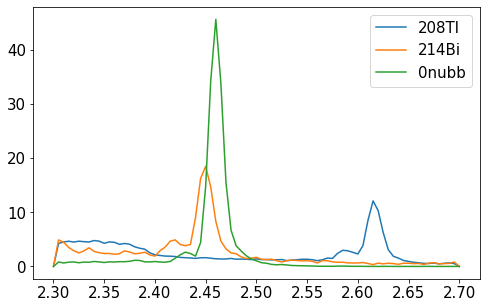

In [8]:
x = np.arange(x1, x2, dx)

fig, ax = plt.subplots(1, 1, figsize=[8, 5])
for i in PDF.args_order:
    ns = [0]*len(PDF.args_order)
    ns[i] = 1
    
    plt.plot(x, PDF.pdf(x, *ns), label=PDF.args_order[i])
plt.legend();

# Test fits

First we present and example of fit for a given set of activities. The procedure is as follow:
- Set the activities
- Compute the number of events for each component and randomly select them from data
- Select the energy range of interest and compute the number of events for each component in this range
- Perform the fit

Then we do exactly the same for multiple experiments to check the fit result compatibility.

In [9]:
# activities (mBq) 1Bq = 1/s
A_214Bi = 10  * units.mBq
A_208Tl = 10  * units.mBq
A_0nubb = 0.5 * units.mBq

total_time = 10 * units.day

number_events = {"214Bi": int(A_214Bi*total_time), 
                 "208Tl": int(A_208Tl*total_time),
                 "0nubb": int(A_0nubb*total_time)}

# generate experiment
experiment = []
for background, df in summary.groupby("background"):    
    experiment.append(df.sample(n=number_events[background]))
experiment = pd.concat(experiment).sample(frac=1)

In [10]:
# select energy range
roi = experiment[(x1<=experiment["evt_energy"])&(experiment["evt_energy"]<=x2)]
energy = roi["evt_energy"].values
number_events_roi = dict(roi.groupby("background").apply(lambda df: len(df)))

logL = PDF.eval_logL(energy)

In [11]:
#fit
guess = [len(energy)]*len(PDF.args_order)
m = Minuit(logL, *guess)
m.errordef = Minuit.LIKELIHOOD
m.limits = [(0, 1.2*len(energy))]*len(PDF.args_order)
m.migrad()
m.hesse();

print("{:<8} | {:<8} | {:<8}".format("Name", "Expected", "Result"))
print()
for i in PDF.args_order:
    name = PDF.args_order[i]
    try:
        expected = number_events_roi[name]
    except KeyError:
        expected = 0
    result   = int(m.values[i])
    err      = int(m.errors[i])
    print("{:<8} | {:<8} | {:<8}+- {:<6}".format(name, expected, result, err))
    
chi2dof = compute_chi2dof(energy, bins, PDF.pdf, list(m.values))
print()
print("chi2/dof =", round(chi2dof, 3))

Name     | Expected | Result  

208Tl    | 3417     | 3451    +- 80    
214Bi    | 1178     | 992     +- 80    
0nubb    | 304      | 394     +- 40    

chi2/dof = 1.41


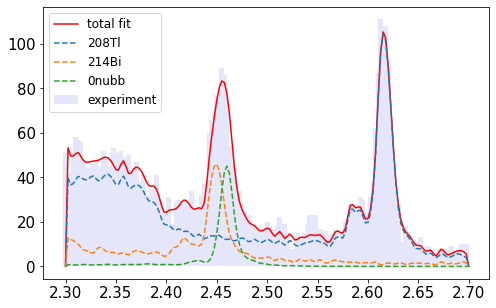

In [12]:
dx_ = dx/2.
x = np.arange(x1, x2, dx_)

fig, ax = plt.subplots(1, 1, figsize=[8, 5])
ax.plot(x, np.sum(m.values)*dx_*PDF.pdf(x, *m.values), c="r", label="total fit")
for i in PDF.args_order:
    p = PDF.collection[PDF.args_order[i]]
    ax.plot(x, m.values[i]*dx_*p.pdf(x), label=PDF.args_order[i], linestyle="--")

h, _ = np.histogram(energy, bins=x)
ax.bar(x[:-1], h, width=dx, color="lavender", alpha=1, label="experiment")
ax.legend(fontsize=12);

In [ ]:
n_exp = 1000
n = 1

results = []
errors  = []
chi2s   = []
while n<=n_exp:
    print("Experiment", n, "/", n_exp, end="\r")
    
    # generate experiment
    experiment = []
    for background, df in summary.groupby("background"):    
        experiment.append(df.sample(n=number_events[background]))
    experiment = pd.concat(experiment).sample(frac=1)

    # select energy range
    roi = experiment[(x1<=experiment["evt_energy"])&(experiment["evt_energy"]<=x2)]
    energy = roi["evt_energy"].values
    number_events_roi = dict(roi.groupby("background").apply(lambda df: len(df)))
    logL = PDF.eval_logL(energy)
    #fit
    guess = [len(energy)]*len(PDF.args_order)
    m = Minuit(logL, *guess)
    m.errordef = Minuit.LIKELIHOOD
    m.limits = [(0, 1.2*len(energy))]*len(PDF.args_order)
    m.migrad()
    m.hesse();

    chi2dof = round(compute_chi2dof(energy, bins, PDF.pdf, list(m.values)), 3)
    
    results.append(list(m.values))
    errors .append(list(m.errors))
    chi2s  .append(chi2dof)
    
    n+=1
    
results = np.array(results)
errors  = np.array(errors)
chi2s   = np.array(chi2s)

In [176]:
plt.figure()
plt.hist(chi2s, bins=100);

/Users/gonzalo/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 50 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [177]:
def gauss_pdf(x, mu, sig):
    return (1/sig)*(1/(2*np.pi)**0.5)*np.exp(-((x-mu)/sig)**2/2)

def gauss_logL(x):
    n = len(x)
    def logL(mu, sig):
        logL_ = -n*np.log(sig) -(1/2.)*np.sum(((x-mu)/sig)**2)
        return -logL_
    return logL

In [193]:
i = 0
x = results[:, i]
logL = gauss_logL(x)

guess = [np.mean(x), np.std(x)]
m = Minuit(logL, *guess)
m.errordef = Minuit.LIKELIHOOD
m.limits = [(min(x), max(x)), (0, max(x)-min(x))]
m.migrad()
m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4693                       │              Nfcn = 37               │
│ EDM = 2.57e-17 (Goal: 0.1)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │ 3.3501e3  │ 0.0021e3  │            │            │ 3152.58 │ 3629.36 │       │
│ 1 │ sig  │   66.5    │    1.5    │            │            │    0    │ 476.779 │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────┐
│     │       mu      sig │
├─────┼───────────────────┤
│  mu │     4.43 0.000212 │
│ sig │ 0.000212     2.21 │
└─────┴───────────────────┘

In [194]:
dx = 5
bins = np.arange(min(x), max(x), dx) 

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[8, 5])
fig.suptitle(PDF.args_order[i])
h, _ = np.histogram(x, bins=bins)
ax0.bar(bins[:-1], h, width=dx, alpha=0.5)
ax0.plot(bins, gauss_pdf(bins, *m.values)*dx*np.sum(h), c="r")

ax1.hist(errors[:, i], bins=100);

/Users/gonzalo/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 50 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …